# 株価予測モデル構築PJT

## データ取得
* yfinanceを使用して、株価データを取得してdfとして格納

In [68]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd
import yfinance as yf

In [ ]:
# 日本取引所グループ(JPX)が提示している東証上場銘柄リストから一覧を取得
# https://www.jpx.co.jp/markets/statistics-equities/misc/01.html
df_company = pd.read_excel("./data/20231216_data_j.xlsx")
df_company

In [35]:
target_company = input("取得対象の銘柄名を入力：")
x = df_company.query(f"銘柄名 == '{target_company}'")["コード"].to_list()

In [37]:
x

[2413]

In [55]:
# yf.download(対象の株銘柄, 期間, 頻度)
ticker = "2413.T"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31", interval="1d")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-06,3260.0,3280.0,3225.0,3240.0,3195.790771,2146300
2020-01-07,3230.0,3350.0,3225.0,3345.0,3299.358154,2060900
2020-01-08,3310.0,3320.0,3210.0,3275.0,3230.313232,2364700
2020-01-09,3340.0,3385.0,3310.0,3385.0,3338.812256,1738300
2020-01-10,3385.0,3445.0,3355.0,3440.0,3393.061768,2004100
...,...,...,...,...,...,...
2023-12-11,2151.0,2175.0,2125.5,2156.5,2156.500000,4094800
2023-12-12,2196.5,2206.0,2140.0,2143.0,2143.000000,2447000
2023-12-13,2155.5,2157.5,2110.0,2127.5,2127.500000,3251100


## 可視化

In [ ]:
# mplfinanceライブラリを使用した、ローソク足グラフの描画
df = data
# df = df.drop("Volume", axis=1)
mpf.plot(df, type="candle", style="yahoo", mav=3, volume=True)  # mav: 移動平均線

In [71]:
# 移動平均値の集計(今回の例では終値(Close)を対象)
price = df["Close"]
span = 30

df["MA_for_30_days"] = price.rolling(window=span, min_periods=1).mean()

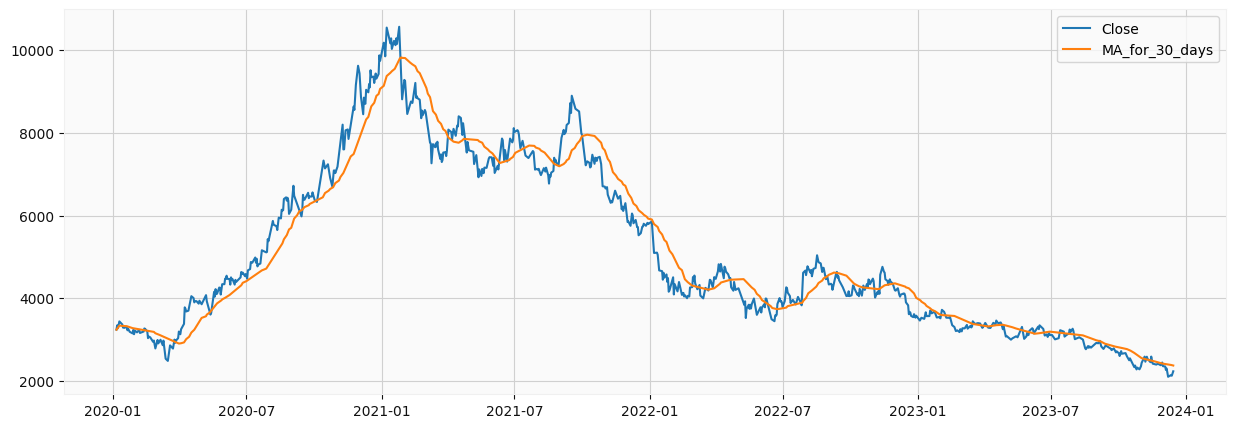

In [73]:
df_ma = df[["Close", "MA_for_30_days"]]
df_ma

plt.figure(figsize=(15, 5))
plt.plot(df_ma.index, df_ma)
plt.legend(df_ma)
plt.show()

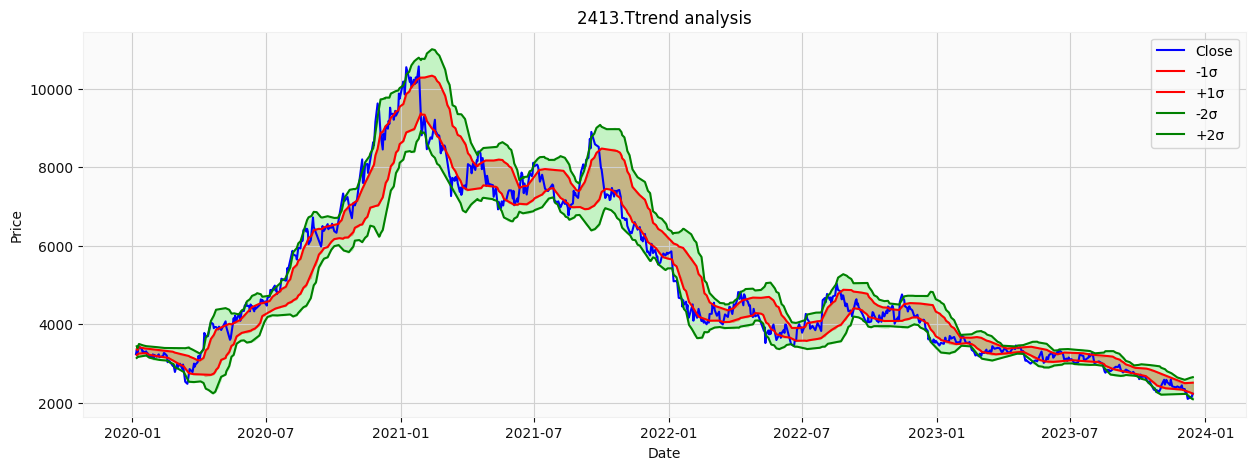

In [76]:
# ボリンジャーバンド
df = data
span = 30
df["MA_for_30_days"] = price.rolling(window=span, min_periods=1).mean()
df["std"] = price.rolling(window=span, min_periods=1).std()

df["-1σ"] = df["MA_for_30_days"] - 1 * df["std"]
df["+1σ"] = df["MA_for_30_days"] + 1 * df["std"]
df["-2σ"] = df["MA_for_30_days"] - 2 * df["std"]
df["+2σ"] = df["MA_for_30_days"] + 2 * df["std"]

plt.figure(figsize=(15, 5))
plt.title(ticker + "trend analysis")
plt.plot(df["Close"], color="blue")
plt.plot(df["-1σ"], color="red")
plt.plot(df["+1σ"], color="red")
plt.plot(df["-2σ"], color="green")
plt.plot(df["+2σ"], color="green")
plt.fill_between(df.index, df["-1σ"], df["+1σ"], color="red", alpha=0.5)
plt.fill_between(df.index, df["-2σ"], df["+2σ"], color="lightgreen", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Close", "-1σ", "+1σ", "-2σ", "+2σ"], loc="upper right")
plt.show()